# 1. Скачивание данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
data = pd.read_csv('/datasets/games.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<h2>Шаг 2. Подготовка данных.</h2>

In [3]:
data.columns = data.columns.str.lower()
data['year_of_release'] = data['year_of_release'].fillna(-1).astype('int64')
data['critic_score'] = data['critic_score'].fillna(-1).astype(np.int64)
data['user_score'] = data['user_score'].replace('tbd', -2).fillna(-1).astype('float64')
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']

+ решил, что tbd значит to be determined
+ заменил тип 'year_of_release' и 'critic_score' на int64 чтобы не было дробной части
+ заменил тип 'user_score' на float64

<h2>Шаг 3. ИА данных</h2> 

<h4>Распределение количества проданных игр по годам</h4>

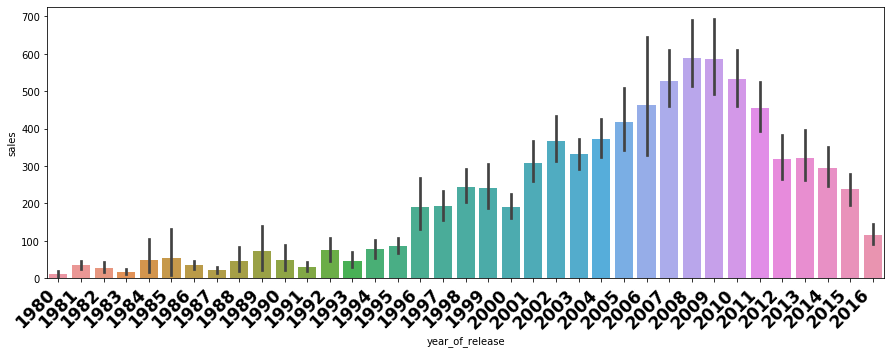

In [4]:
plt.rcParams['figure.figsize']=(15,5)
sb.barplot(x='year_of_release', y='sales', data=data[data['year_of_release']>0], estimator=sum)
bars = tuple(range(1980,2017))
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars, rotation=45, fontweight='bold', fontsize='17', horizontalalignment='right')
plt.show()

<h4>Определение срока жизни успешной платформы</h2>

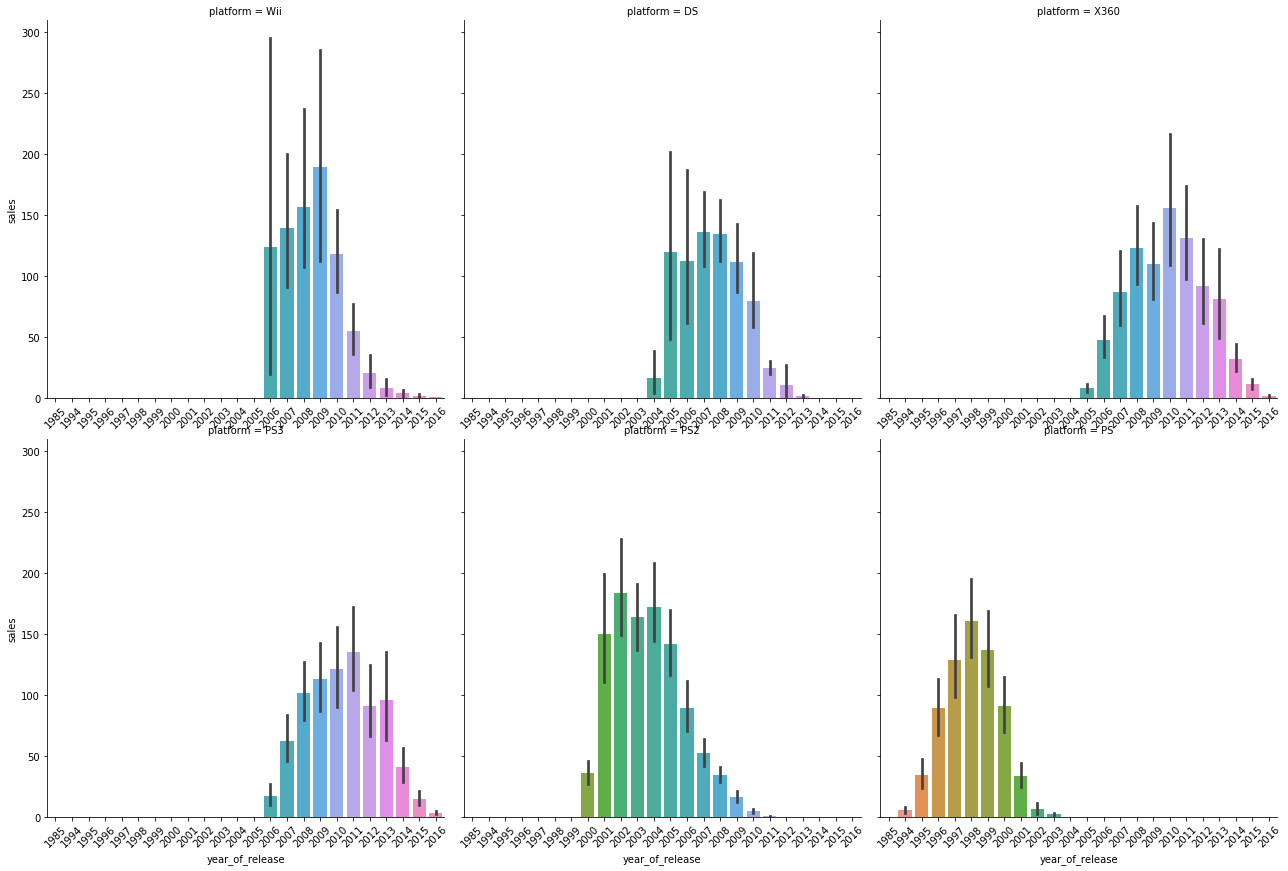

In [5]:
pivot_platforms = data.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False).head(6)
leaders = data[data['year_of_release']>0].query('platform in @pivot_platforms.index')
g = sb.catplot('year_of_release',"sales", col="platform", col_wrap=3, data=leaders, estimator=sum, kind="bar", height=6, aspect=1, sharex=False)
g.set_xticklabels(rotation=45)
plt.show()

Взял только первые 6 платформ, потому что разрыв между PS и следующей в списке очень и очень заметный (игр для PS продано чуть ли не в 2 раза больше). Ориентировочно 9 лет живет средняя успешная платформа


In [6]:
p_lifespan = leaders[leaders['year_of_release']>1992].pivot_table(index='platform', values='year_of_release', aggfunc=['max', 'min'])
print('средняя продолжительность около {} лет'.format(int(np.mean(p_lifespan['max']-p_lifespan['min']))))
p_lifespan

средняя продолжительность около 10 лет


,max,min
,year_of_release,year_of_release
platform,,
DS,2013,2004
PS,2003,1994
PS2,2011,2000
PS3,2016,2006
Wii,2016,2006
X360,2016,2005


<h4>Выделение данных за актуальный период</h4>

Включаю в данные за актуальный период лишь данные платформ, которые показывают сколько нибудь заметные результаты в период с 2011 по 2016 год (примерно половина срока жизни)

In [8]:
raw_actual = data[data['year_of_release'] >= 2011].copy()
raw_sales = raw_actual.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(by='sales', ascending=False).head(9)
actual = raw_actual.query('platform in @raw_sales.index').reset_index(drop=True)
actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,17.09
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,14.86
2,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88,3.4,M,13.41
3,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,NaN,12.25
4,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,NaN,13.82


<h4>Выявление лидеров, развивающихся и переживающих спад платформ</h4>

список лидирующих платформ уже есть -- raw_sales

можно, условно, взять первые 5 платформ -- они и будут лидирующими

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


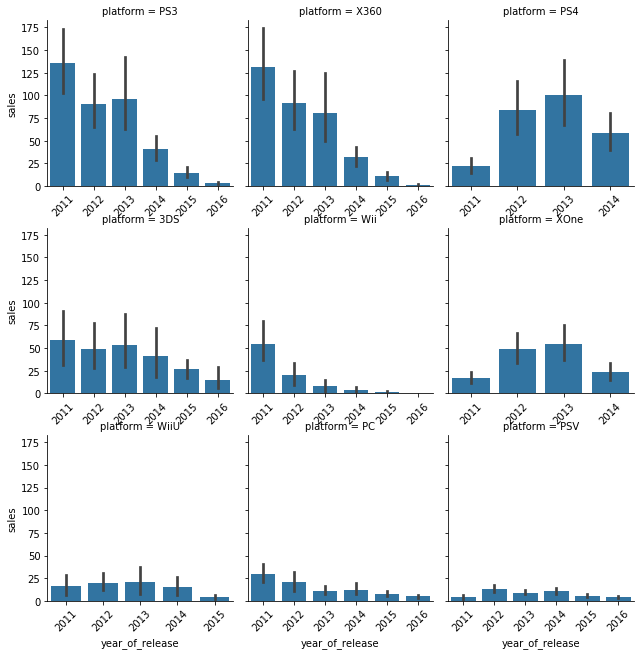

In [9]:
dvlpng = sb.FacetGrid(actual, col='platform', col_wrap=3, sharex=False)
dvlpng = dvlpng.map(sb.barplot, 'year_of_release','sales', estimator=sum)
dvlpng.set_xticklabels(rotation=45)
plt.show()

ну что ж картина достаточно мутная и странная, у всез платформ намечается резкий спад, но попробую что-нибудь предсказать: возможно стоит обратить внимание на платформы ps4, xOne, не стоит упускать из вида 3DS, прочие же платформы показывают однозначый спад по продажам, можно их исключить из рассмотрения

In [11]:
actual_pivot = actual.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').reset_index().fillna(0)
actual_pivot['year_of_release'] = pd.to_numeric(actual_pivot['year_of_release'])#.astype('float64')
print('Показатели корреляции между временем и числом проданных игр на конкретной платформе')
actual_pivot.corr().head(1)

Показатели корреляции между временем и числом проданных игр на конкретной платформе


platform,year_of_release,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
platform,,,,,,,,,,
year_of_release,1.0,-0.940647,-0.939409,-0.971758,0.812676,-0.292737,-0.853316,0.114021,-0.980874,0.715882


Возможно, я где-то накосячил (сомнения вызывает возможность существования каких то проблем у платформы PC), но в целом, показатели соответствуют действительности

еще одно сомнение возникло по поводу того что я анализирую период равный жизни средней платформы

третье сомнение: возможно использовать корреляцию для малого числа данных не очень корректно
по крайней мере склонность к развитию платформ PS4 и XOne несомненна

<h4>Ящики с усами по платформам</h4>

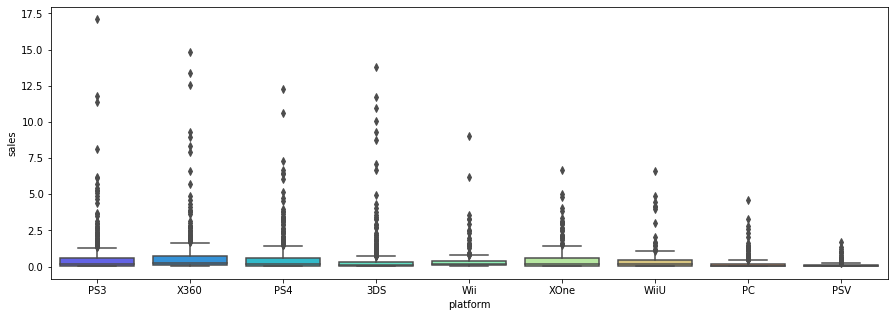

In [12]:
sb.boxplot(x='platform', y='sales', data=actual, palette='rainbow')
plt.show()

видно, что большинство игр продаются малыми тиражами, а успешные игры скорее исключение из правил

тем не менее видно, что успешные игры продаются очень и очень хорошо


<h4>Влияние отзывов на продажи</h4>

In [13]:
reviews_pivot_rate = actual[(actual['user_score']>-1) & (actual['critic_score']>-1)].pivot_table(index = 'platform', values=['user_score', 'critic_score'], aggfunc='count')
reviews_pivot_rate['total'] = reviews_pivot_rate['critic_score'] + reviews_pivot_rate['user_score']
reviews_pivot_rate.sort_values(by='total', ascending=False)

,critic_score,user_score,total
platform,,,
PS3,342,342,684
X360,292,292,584
PC,288,288,576
PS4,249,249,498
XOne,165,165,330
3DS,156,156,312
PSV,118,118,236
WiiU,89,89,178
Wii,42,42,84


будем исследдовать PS3 как платформу с наибольшим числом данных

<font color=orange> UPD: Исследую также всю выборку целиком просто чтобы оценить репрезентативность выборки по платформе PS3

,critic_score,user_score
sales,0.327001,0.032620
sales,0.379949,0.023903


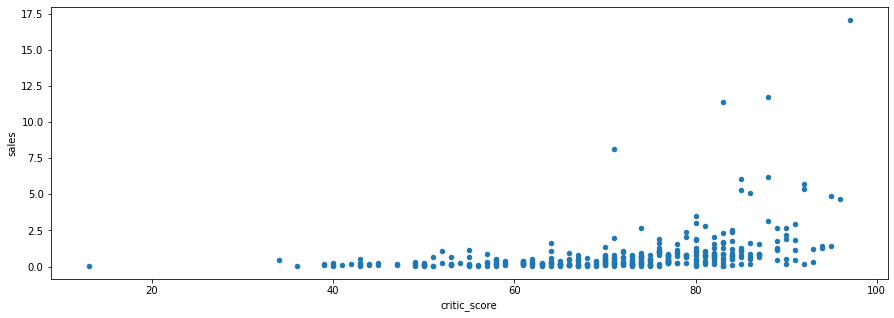

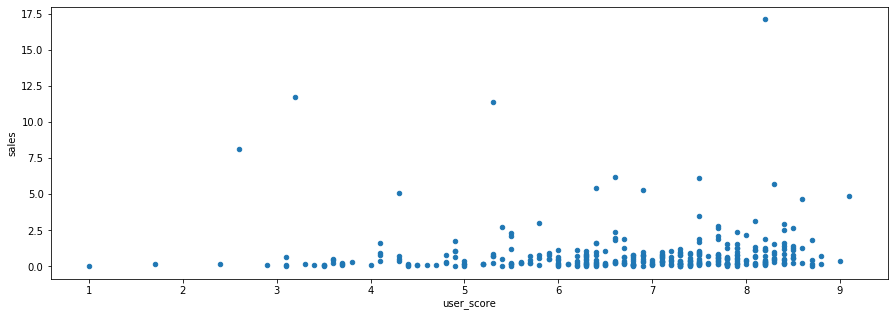

In [14]:
ps3 = actual[(actual['platform']=='PS3') & (actual['user_score']>-1) & (actual['critic_score']>-1)].copy().reset_index(drop=True)
ps3.plot.scatter(x='critic_score', y='sales')
ps3.plot.scatter(x='user_score', y='sales')

all_ = actual[(actual['user_score']>-1) & (actual['critic_score']>-1)].copy()
pd.concat([all_.corr()[['critic_score', 'user_score']].tail(1), ps3.corr()[['critic_score', 'user_score']].tail(1)])

Вывод1: мнение профессиональных критиков (user_score формируется из оценок критиков-любителей) более объективно, хотя нельзя не отметить большое число игр, полюбившихся довольно узкой аудитории

Вывод2: кажется вполне естественным экстраполировать вывод, полученный для платформы PS3 на все прочие

значения корреляции для выборки по платформе PS3 незначительно отличаются от значений корреляции для выборке по всем успешным платформам, соответственно выборку по платформе PS3 можно считать представительной

<h4>Исследование игр по жанрам</h4>

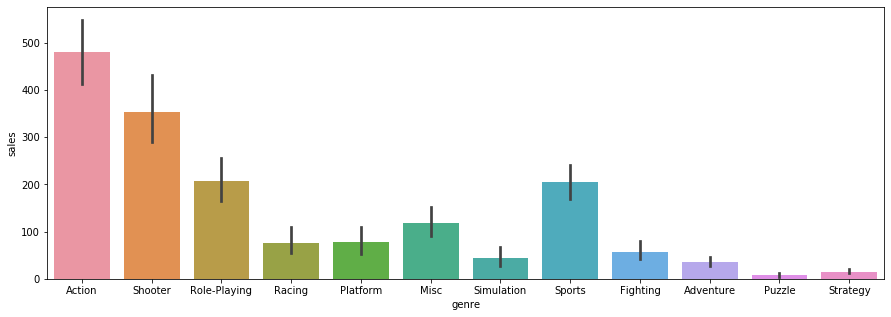

In [16]:
plt.rcParams['figure.figsize']=(15,5)
sb.barplot(x='genre', y='sales',data=actual, estimator=sum)
plt.rcParams['figure.figsize']=(15,5)

Самые прибыльные жанры -- Action, Shooter, Role-Playing, Sports. Все прочие заметно отстают по показателю прибыльности.

In [17]:
leaders[leaders['name']=='Grand Theft Auto V']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,17.09
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,14.86


In [19]:
leaders[(leaders['genre']=='Puzzle') & (leaders['sales']>leaders['sales'].mean())].reset_index(drop=True).shape

(39, 12)

<h6>Да, жанры Action и Shooter весьма дороги в разработке, но вполне естественно в данной ситуации полагать (увы ничего другого нам не остается, тк нет данных о стоимости продукции и стоимости разработки), что издатель закладывал цену игры исходя из затрат на производство и данных о средней величине продаж. Ранее был представлен график box_plot для различных платформ. Конечно это не совсем о жанрах, но тк каждая точка означает продажи конкретной игры, можно сделать вывод, что в среднем игры продаются одинаково, и эти средние значения очень невелики по сравнению с лидерами (продажи которых box_plot определяет как выбросы т.е. аномалии). </h6>
   
<h6>Следующая моя мысль вполне очевидна, но я все же, для большей ясности, явно ее обозначу. Если в целом (если не брать во внимание выбросы) все игры продаются одинаково, чем же вызваны столь значительные показатели продаж игр жанров Action и Shooter? Как раз вот этими выбросами. А в жанре Puzzle увы набралось всего 38 представителей с показателем продаж большим среднего.</h6>

<h6>Далее легко сделать вывод, что игры жанра Action и Shooter, имеющие в среднем более высокую стоимость разработки, а значит более высокую цену приносят прямо-таки колоссальные доходы своим издателям.</h6>

<h2>Шаг 4. Составление агрегированного портрета пользователя по регионам</h2>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and 

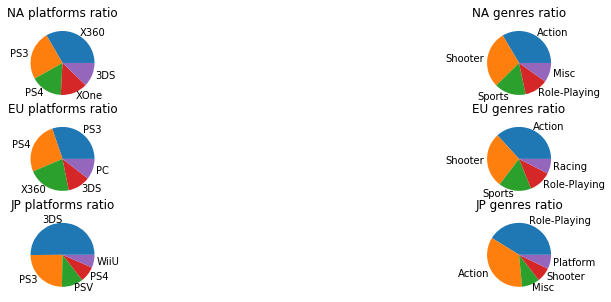

In [21]:
na_leaders_pl = actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).head(5)
na_leaders_ge = actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).head(5)
eu_leaders_pl = actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).head(5)
eu_leaders_ge = actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).head(5)
jp_leaders_pl = actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).head(5)
jp_leaders_ge = actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).head(5)
fig, ax = plt.subplots(3,2)

ax[0,0].pie(na_leaders_pl, labels=na_leaders_pl.index)
ax[0,0].set_title('NA platforms ratio')

ax[0,1].pie(na_leaders_ge, labels=na_leaders_ge.index)
ax[0,1].set_title('NA genres ratio')

ax[1,0].pie(eu_leaders_pl, labels=eu_leaders_pl.index)
ax[1,0].set_title('EU platforms ratio')

ax[1,1].pie(eu_leaders_ge, labels=eu_leaders_ge.index)
ax[1,1].set_title('EU genres ratio')

ax[2,0].pie(jp_leaders_pl, labels=jp_leaders_pl.index)
ax[2,0].set_title('JP platforms ratio')

ax[2,1].pie(jp_leaders_ge, labels=jp_leaders_ge.index)
ax[2,1].set_title('JP genres ratio')
plt.rcParams['figure.figsize']=(8,12)

plt.show()

Графики говорят сами за себя, но вкратце различия по регионам можно описать следующим образом:

- Рынок JP очень сильно отличается от мирового, превалирует платформа 3DS, а по жанрам лидирующее положение занимает Role-Playing, который совсем не популярен в других регионах
- Рынки EU и NA очень похожи, единственное отличие заключается в том, что структура рынка NA более высококонкурентна: все популярные платформы занимают весомую часть рынка


<h4>Влияние возрастных рейтингов</h4>

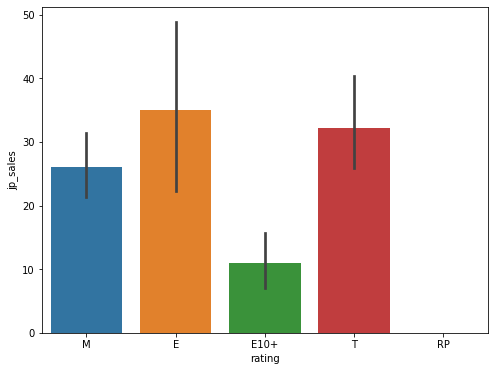

In [22]:
plt.rcParams['figure.figsize']=(8,6)
sb.barplot(x='rating', y='jp_sales',data=actual, estimator=sum)
plt.show()

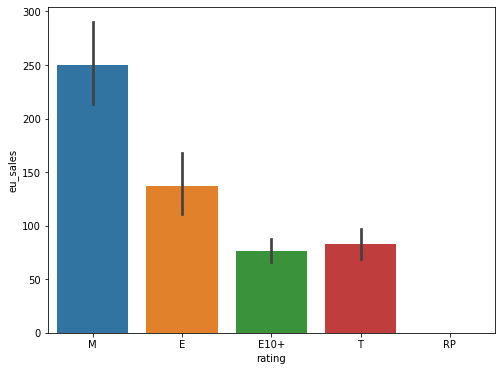

In [23]:
sb.barplot(x='rating', y='eu_sales',data=actual, estimator=sum)
plt.show()

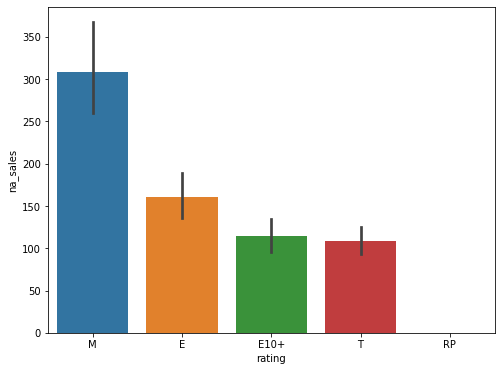

In [24]:
sb.barplot(x='rating', y='na_sales',data=actual, estimator=sum)
plt.show()

Видно что рынок JP опять отличается от остальных, там не прослеживается какой-либо внятной связи между уровнем продаж и возрастным рейтингом игр. На рынках NA и EU лучше продаются игры, предназначенные для широкого круга игроков

Хотел бы еще более ясно обозначить, что именно может дать отсутствие видимой связи между возрастными ограничениями и продажами в регионе JP. Рынок JP можно считать своего рода полем для экспериментов, там с большей вероятностью могут выстрелить сложные, неоднозначные, небанальные, новаторские проекты, попытка реализации которых на куда более традиционных рынках EU и NA была бы сопряжена с куда более значительным риском

<h2>Шаг 5. Проверка гипотез</h2>

<h4>H0 = Средние пользовательские рейтинги платформ Xbox One и PC одинаковые</h4>

In [25]:
from scipy import stats as st
alpha = .05
x_one_r = actual[(actual['platform']=='XOne') & (actual['user_score']>=0)][['user_score']]
pc_r = actual[(actual['platform']=='PC') & (actual['user_score']>=0)][['user_score']]
results = st.ttest_ind(
    x_one_r, 
    pc_r)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.62676023]
Не получилось отвергнуть нулевую гипотезу


Вывод: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


<h4>H0=Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые</h4>

In [26]:
actn_r = actual[(actual['genre']=='Action') & (actual['user_score']>=0)][['user_score']]
sprts_r = actual[(actual['genre']=='Sports') & (actual['user_score']>=0)][['user_score']]
results = st.ttest_ind(
    actn_r, 
    sprts_r)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [1.42376095e-23]
Отвергаем нулевую гипотезу


Вывод: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

В соответствии с проведенным анализом, при составлении бизнес-стратегии на 2017 год должны учитываться следующие положения:

+ стратегии по направлениям EU/NA и JP должны различаться, тк структуры рынков NA и EU практически идентичны, рынок JP уникален:
    + Следует пристальное внимание уделить развивающимся платформам PS4 и XOne (по всему миру), в регионе JP приоритетной платформой должна быть 3DS, высоких продаж игр прочих платформ ожидать не следует
    + Самым популярным жанром во всем мире является Action, в объединенном регионе EU/NA также очень популярен жанр Shooter, в регионе JP -- Role-Playing
    + В регионе JP рейтинг игр слабо влияет на уровень продаж, тогда как в регионе EU/NA большую часть рынка занимают игры с низким возрастным ограничением